In [38]:
import sys
print(sys.path)

['/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python310.zip', '/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python3.10', '/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python3.10/lib-dynload', '', '/opt/homebrew/Caskroom/miniforge/base/envs/fast/lib/python3.10/site-packages']


In [39]:
import dotenv

In [40]:
# expecting AZURE_SEARCH_KEY=<key> in .env file
dotenv.load_dotenv('.env')
key = os.environ.get('AZURE_SEARCH_KEY', 'XXX')
print('successfully fetched env vars')

successfully fetched env vars


In [58]:
comic_collections_dict = {
    'the far side': 'tfs',
    'xkcd': 'xk',
    'dilbert': 'dbt',
    'pearls before swine': 'pbs',
    'rhymes with orange': 'rwo',
    'hägar the horrible': 'hth',
    'in the bleachers': 'itb'
}

comic_collections = comic_collections_dict.keys()

path = Path('comics')

In [60]:
if path.exists():
    print(f'{os.path.abspath(path)} exists. Skipping downloading of images.')
else:
    path.mkdir()
    for name, abbr in comic_collections_dict.items():
        print(f'searching for "{name}" comics...')
        dest = (path/abbr)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{name} comics')
        print(f'downloading "{name}" comics...')
        download_images(dest, urls=results.attrgot('contentUrl'))
        print('done.')

searching for "the far side" comics...
downloading "the far side" comics...
done.
searching for "xkcd" comics...
downloading "xkcd" comics...
done.
searching for "dilbert" comics...
downloading "dilbert" comics...
done.
searching for "pearls before swine" comics...
downloading "pearls before swine" comics...
done.
searching for "rhymes with orange" comics...
downloading "rhymes with orange" comics...
done.
searching for "hägar the horrible" comics...
downloading "hägar the horrible" comics...
done.
searching for "in the bleachers" comics...
downloading "in the bleachers" comics...
done.


In [61]:
files = get_image_files(path)
print(f'{len(files)} attempted downloads')

930 attempted downloads


In [62]:
failed = verify_images(files)
print(f'{len(failed)} failed downloads')

34 failed downloads


In [63]:
print('cleaning up failed downloads...')
failed.map(Path.unlink);
print('done.')

cleaning up failed downloads...
done.


In [64]:
comics = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(256)
)

In [65]:
dls = comics.dataloaders(path)

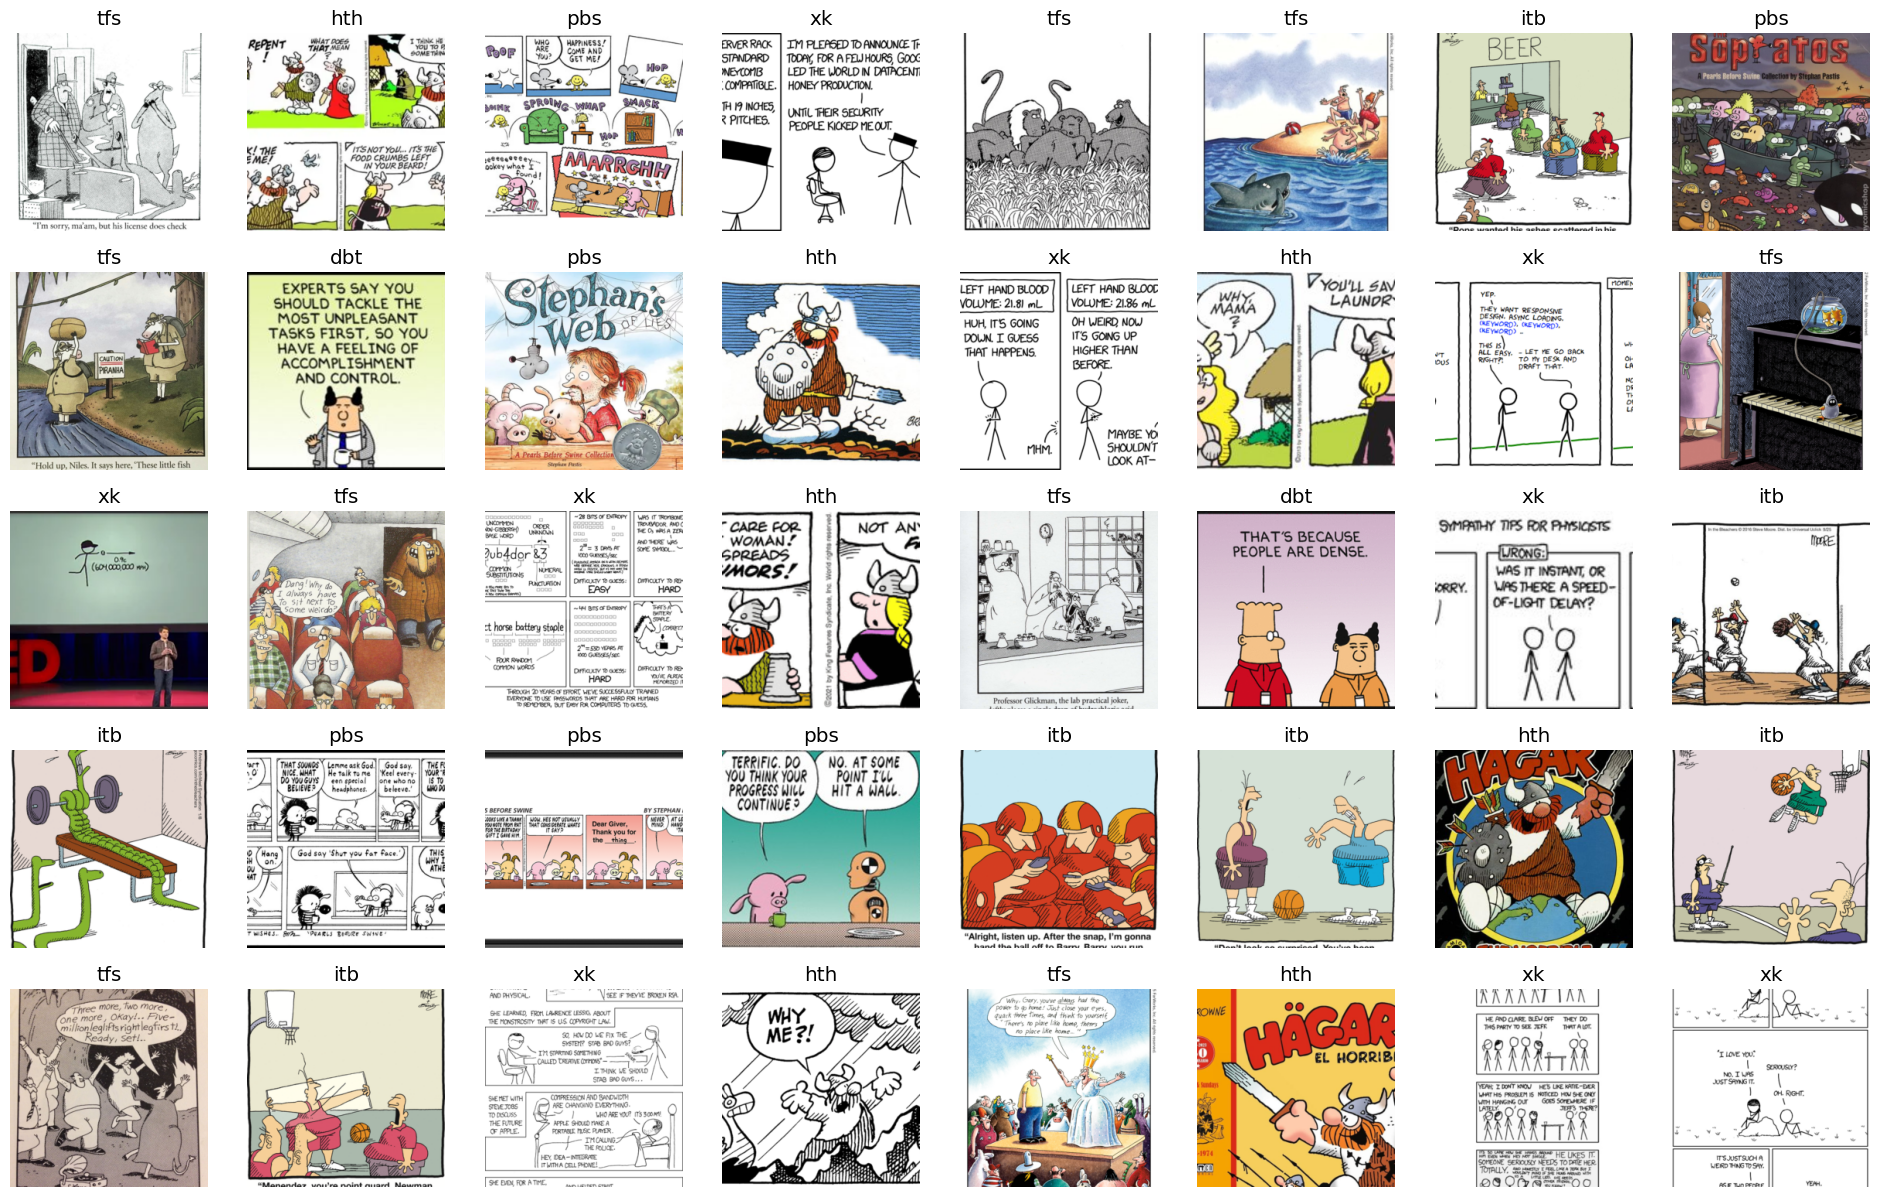

In [66]:
dls.valid.show_batch(max_n=40, nrows=5)

In [67]:
comics = comics.new(item_tfms=Resize(256), batch_tfms=aug_transforms(mult=2))
dls = comics.dataloaders(path)
dls.train.show_batch(max_n=40, nrows=5, unique=True)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [68]:
comics = comics.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = comics.dataloaders(path)

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


NotImplementedError: The operator 'aten::_linalg_solve_ex.result' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

In [69]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.175053,0.737841,0.234637,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.618183,0.387012,0.122905,00:25
1,0.442444,0.264136,0.094972,00:24
2,0.330755,0.250261,0.067039,00:23
3,0.255548,0.243878,0.067039,00:25


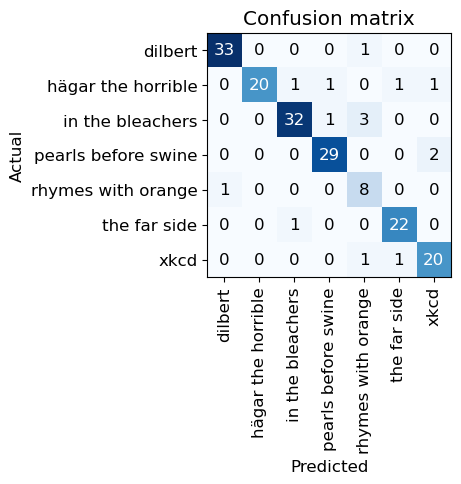

In [34]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

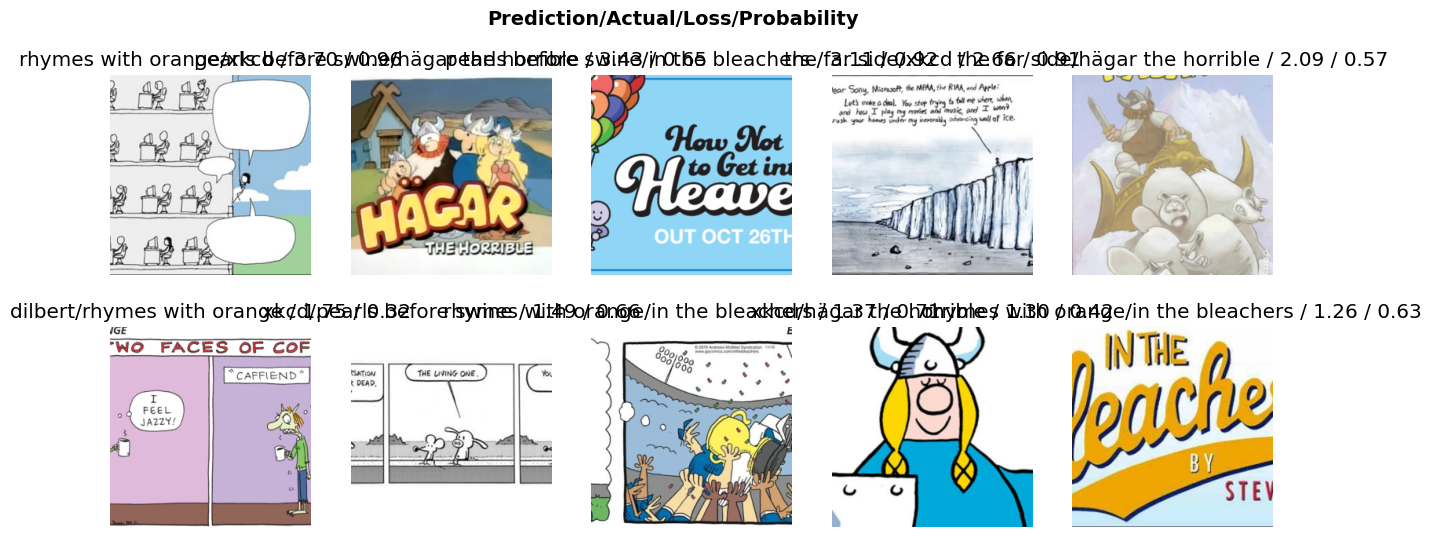

In [36]:
interp.plot_top_losses(10, nrows=2)

In [37]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')